# WeRateDogs Data Wrangling Project

**Project Background:**
<br>
The dataset used below is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage. 

<br>

**Project Introduction:**
<br>
This project wrangled WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. Step 1, data was gathered from 3 resources: the first was already downloaded and stored locally, and the second was downloaded from an url, while the third was acquired from Twitter API. Data from these 3 sources was then assessed in Step 2. Both data quality issues and tidiness issues were identified. Step 3 intended to solve the issues identified in the last step, and all three datasets were cleaned. The last step, Step 4, data was analyzed and visualized. However, the main goal of this project is to gain skills in gathering, assessing, and cleaning data. Therefore, Step 1 to Step 3 were the focus of this analysis.

## Content: 
<br> 
[Step 1: Gather data from 3 sources](#step1)
<br>

- 1.1 Gathering Source 1: Enhanced Twitter Archive (already at hand)
- 1.2 Gathering Source 2: Image Predictions File (use requests.get(url))
- 1.3 Gathering Source 3: Twitter API (use API)
- Summary for Step 1 (Data Gathering)
<br>

[Step 2: Assess](#step2)
<br> 
- 2.1 Look at 'twitter_archive_master.csv''s issues
- 2.2 Look at 'twitter_predict.csv''s issues
- 2.3 Look at 'selected_attr.csv''s issues
- Summary for Step 2 (Assess)
<br>

[Step 3: Clean](#step3)
<br>
- 3.1 Clean df_archive_main ('twitter_archive_master.csv')
- 3.2 Clean df_predict ('twitter_predict.csv')
- 3.3 Clean df_selected_attr ('selected_attr.csv')
- 3.4 Merge 3 dfs
- 3.5 Store cleaned dataframe
<br>

[Step 4: Analyze](#step4)
<br> 
- 4.1 Tweets posted during which time receive more favorites? 
- 4.2 Tweets posted during which time get more retweets?
- 4.3 Is there a relationship between rating and favourites?
- 4.4 Is there a relationship between rating and retweet?

In [1]:
import tweepy
import json
import pandas as pd
import requests
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(color_codes=True)

<a id='step1'></a>
## Step 1: Gather data from 3 sources
Process Overview:

Develop some code to create an API object to gather Twitter data. After querying each tweet ID, write its JSON data to a tweet_json.txt file with each tweet's JSON data on its own line. Then read this file, line by line, to create a pandas DataFrame that will then be assessed and cleaned. 

### `1.1` Gathering Source 1: Enhanced Twitter Archive (already at hand)
The WeRateDogs Twitter archive. I am giving this file to you, so imagine it as a file on hand. File name: "twitter_archive_enhanced.csv"

In [2]:
# Get all user_id
df_tw_arch_raw = pd.read_csv('twitter-archive-enhanced.csv')
df_tw_arch_raw.head(2)
all_tweet_ids = df_tw_arch_raw['tweet_id'].tolist()
all_tweet_ids

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [3]:
# See which cols have missing values, so that we can get these values from API (Source 3)
df_tw_arch_raw.info()
# missing values: in_reply_to_status_id , in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### `1.2` Gathering Source 2: Image Predictions File (use requests.get(url) )
The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [4]:
# Ref1: https://tobiasraabe.github.io/blog/how-to-download-files-with-python.html
# Ref2: https://www.youtube.com/watch?v=tb8gHvYlCFs

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
response.content
# dir(response) 
help(response) # Result shows: Content in bytes; text in unicode.

# Create a file called "image_predictions.tsv". Write to this file. 
# After the code below, you can see this file in your laptop.
with open('image_predictions.tsv','wb') as file:
    file.write(response.content)

Help on Response in module requests.models object:

class Response(builtins.object)
 |  The :class:`Response <Response>` object, which contains a
 |  server's response to an HTTP request.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if the status code of the response is between
 |      400 and 600 to see if there was a client error or a server error. If
 |      the status code, is between 200 and 400, this will return True. This
 |      is **not** a check to see if the response code is ``200 OK``.
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |      Allows you to use a response as an iterator.
 |  
 |  __nonzero__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if

In [5]:
# Open the file we just created.
df_predict_raw = pd.read_csv('image_predictions.tsv', sep='\t')
df_predict_raw.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


### `1.3` Gathering Source 3: Twitter API (use API)
Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive (See Source 1), query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.


In [6]:
# Create an API object that you can use to gather Twitter data.
# Ref: "Getting started" portion in Tweepy documentation
consumer_key = 'S0d9EJUerYukTbWyk6s4949As'
consumer_secret = 'Im5iI2WxIA9u8BTMpi0ugu9fICNyLeoEKJG90cVsH3y0bB2sUE'
access_token = '1068535408550658051-GY6iXvEgp6VsLCH73N5ub4tgwSuFpb'
access_secret = 'Ww9JXMnGsuRzXfO4VTRXIUjw1pBiOcGBoakr7fzktVcd4'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

##### Writing and Reading Twitter JSON
> Tweet data is stored in JSON format by Twitter. Getting tweet JSON data via tweet ID using Tweepy is described well in this StackOverflow answer (https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id). Note that setting the tweet_mode parameter to 'extended' in the get_status call, i.e., api.get_status(tweet_id, tweet_mode='extended'), can be useful. Also, note that the tweets corresponding to a few tweet IDs in the archive may have been deleted. Try-except blocks may come in handy here.
<br>
After querying each tweet ID, you will write its JSON data to the required tweet_json.txt file with each tweet's JSON data on its own line. You will then read this file, line by line, to create a pandas DataFrame that you will soon assess and clean. This Reading and Writing JSON to a File in Python article from Stack Abuse, will be useful (https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/).




##### Twitter's Rate Limit:
> Twitter's API has a rate limit. Rate limiting is used to control the rate of traffic sent or received by a server. As per Twitter's rate limiting info page: Rate limits are divided into 15 minute intervals. 
<br>
To query all of the tweet IDs in the WeRateDogs Twitter archive, 20-30 minutes of running time can be expected. Printing out each tweet ID after it was queried and using a code timer were both helpful for sanity reasons. Setting the wait_on_rate_limit and wait_on_rate_limit_notify parameters to True in the tweepy.api class is useful as well. (Used in cell above)

See: https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy



In [9]:
# Step 1: get tweet JSON data via tweet ID (using Tweepy)
# Step 2: write its JSON data to the required "tweet_json.txt" file with each tweet's JSON data on its own line. (Store each tweet's entire set of JSON data in "tweet_json.txt" file.
# Step 3: (See next cell) read this "tweet_json.txt" file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

count = 0 # to keep track of loop
fails_dict = {}

with open ("tweet_json.txt","w") as outfile: # Step 2  # Create a file, name it "tweet_json.txt", and write to it
    for tweet_id in all_tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))  # to keep track of loop
        
        # tweets corresponding to a few tweet IDs in 'twitter-archive-enhanced.csv' may have been deleted. Use try-except.
        try:
            tweet = api.get_status(tweet_id,tweet_mode='extended') # Step 1
            # print(tweet.full_text)  ->  this only prints the tweet's full_text 
            # print(tweet)  -> to find what's inside each tweet's JSON (ex. retweet_count, ...)
            # from line above, we can know that we can get tweet JSON data using: tweet._json

            json.dump(tweet._json, outfile) # Step 2
            outfile.write('\n') # Each tweet's JSON data on its OWN line
            # break
            
        except tweepy.TweepError as e:
            print("Failed")
            fails_dict[tweet_id] = e
            pass 

# Ref1: https://stackoverflow.com/questions/44581647/retrieving-a-list-of-tweets-using-tweet-id-in-tweepy
# Ref2: https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
# Ref3: https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id


1: 892420643555336193
2: 892177421306343426
3: 891815181378084864
4: 891689557279858688
5: 891327558926688256
6: 891087950875897856
7: 890971913173991426
8: 890729181411237888
9: 890609185150312448
10: 890240255349198849
11: 890006608113172480
12: 889880896479866881
13: 889665388333682689
14: 889638837579907072
15: 889531135344209921
16: 889278841981685760
17: 888917238123831296
18: 888804989199671297
19: 888554962724278272
20: 888202515573088257
Failed
21: 888078434458587136
22: 887705289381826560
23: 887517139158093824
24: 887473957103951883
25: 887343217045368832
26: 887101392804085760
27: 886983233522544640
28: 886736880519319552
29: 886680336477933568
30: 886366144734445568
31: 886267009285017600
32: 886258384151887873
33: 886054160059072513
34: 885984800019947520
35: 885528943205470208
36: 885518971528720385
37: 885311592912609280
38: 885167619883638784
39: 884925521741709313
40: 884876753390489601
41: 884562892145688576
42: 884441805382717440
43: 884247878851493888
44: 884162670

343: 832088576586297345
344: 832040443403784192
345: 832032802820481025
346: 831939777352105988
347: 831926988323639298
348: 831911600680497154
349: 831670449226514432
350: 831650051525054464
351: 831552930092285952
352: 831322785565769729
353: 831315979191906304
354: 831309418084069378
355: 831262627380748289
356: 830956169170665475
357: 830583320585068544
358: 830173239259324417
359: 830097400375152640
360: 829878982036299777
361: 829861396166877184
362: 829501995190984704
363: 829449946868879360
364: 829374341691346946
Failed
365: 829141528400556032
366: 829011960981237760
367: 828801551087042563
368: 828770345708580865
369: 828708714936930305
370: 828650029636317184
371: 828409743546925057
372: 828408677031882754
373: 828381636999917570
374: 828376505180889089
375: 828372645993398273
376: 828361771580813312
377: 828046555563323392
378: 828011680017821696
379: 827933404142436356
380: 827653905312006145
381: 827600520311402496
382: 827324948884643840
383: 827228250799742977
Failed
38

684: 788412144018661376
685: 788178268662984705
686: 788150585577050112
687: 788070120937619456
688: 788039637453406209
689: 787810552592695296
690: 787717603741622272
691: 787397959788929025
692: 787322443945877504
693: 787111942498508800
694: 786963064373534720
695: 786729988674449408
696: 786709082849828864
697: 786664955043049472
698: 786595970293370880
699: 786363235746385920
700: 786286427768250368
701: 786233965241827333
702: 786051337297522688
703: 786036967502913536
704: 785927819176054784
705: 785872687017132033
706: 785639753186217984
707: 785533386513321988
708: 785515384317313025
709: 785264754247995392
710: 785170936622350336
711: 784826020293709826
712: 784517518371221505
713: 784431430411685888
714: 784183165795655680
715: 784057939640352768
716: 783839966405230592
717: 783821107061198850
718: 783695101801398276
719: 783466772167098368
720: 783391753726550016
721: 783347506784731136
722: 783334639985389568
723: 783085703974514689
724: 782969140009107456
725: 78274713452

Rate limit reached. Sleeping for: 628


902: 758474966123810816
903: 758467244762497024
904: 758405701903519748
905: 758355060040593408
906: 758099635764359168
907: 758041019896193024
908: 757741869644341248
909: 757729163776290825
910: 757725642876129280
911: 757611664640446465
912: 757597904299253760
913: 757596066325864448
914: 757400162377592832
915: 757393109802180609
916: 757354760399941633
917: 756998049151549440
918: 756939218950160384
919: 756651752796094464
920: 756526248105566208
921: 756303284449767430
922: 756288534030475264
923: 756275833623502848
924: 755955933503782912
925: 755206590534418437
926: 755110668769038337
927: 754874841593970688
928: 754856583969079297
929: 754747087846248448
930: 754482103782404096
931: 754449512966619136
932: 754120377874386944
933: 754011816964026368
Failed
934: 753655901052166144
935: 753420520834629632
936: 753398408988139520
937: 753375668877008896
938: 753298634498793472
939: 753294487569522689
940: 753039830821511168
941: 753026973505581056
942: 752932432744185856
943: 7529

1234: 712809025985978368
1235: 712717840512598017
1236: 712668654853337088
1237: 712438159032893441
1238: 712309440758808576
1239: 712097430750289920
1240: 712092745624633345
1241: 712085617388212225
1242: 712065007010385924
1243: 711998809858043904
1244: 711968124745228288
1245: 711743778164514816
1246: 711732680602345472
1247: 711694788429553666
1248: 711652651650457602
1249: 711363825979756544
1250: 711306686208872448
1251: 711008018775851008
1252: 710997087345876993
1253: 710844581445812225
1254: 710833117892898816
1255: 710658690886586372
1256: 710609963652087808
1257: 710588934686908417
1258: 710296729921429505
1259: 710283270106132480
1260: 710272297844797440
1261: 710269109699739648
1262: 710153181850935296
1263: 710140971284037632
1264: 710117014656950272
1265: 709918798883774466
1266: 709901256215666688
1267: 709852847387627521
1268: 709566166965075968
1269: 709556954897764353
1270: 709519240576036864
1271: 709449600415961088
1272: 709409458133323776
1273: 709225125749587968


1562: 688385280030670848
1563: 688211956440801280
1564: 688179443353796608
1565: 688116655151435777
1566: 688064179421470721
1567: 687841446767013888
1568: 687826841265172480
1569: 687818504314159109
1570: 687807801670897665
1571: 687732144991551489
1572: 687704180304273409
1573: 687664829264453632
1574: 687494652870668288
1575: 687480748861947905
1576: 687476254459715584
1577: 687460506001633280
1578: 687399393394311168
1579: 687317306314240000
1580: 687312378585812992
1581: 687127927494963200
1582: 687124485711986689
1583: 687109925361856513
1584: 687102708889812993
1585: 687096057537363968
1586: 686947101016735744
1587: 686760001961103360
1588: 686749460672679938
1589: 686730991906516992
1590: 686683045143953408
1591: 686618349602762752
1592: 686606069955735556
1593: 686394059078897668
1594: 686386521809772549
1595: 686377065986265092
1596: 686358356425093120
1597: 686286779679375361
1598: 686050296934563840
1599: 686035780142297088
1600: 686034024800862208
1601: 686007916130873345


Rate limit reached. Sleeping for: 625


1802: 676957860086095872
1803: 676949632774234114
1804: 676948236477857792
1805: 676946864479084545
1806: 676942428000112642
1807: 676936541936185344
1808: 676916996760600576
1809: 676897532954456065
1810: 676864501615042560
1811: 676821958043033607
1812: 676819651066732545
1813: 676811746707918848
1814: 676776431406465024
1815: 676617503762681856
1816: 676613908052996102
1817: 676606785097199616
1818: 676603393314578432
1819: 676593408224403456
1820: 676590572941893632
1821: 676588346097852417
1822: 676582956622721024
1823: 676575501977128964
1824: 676533798876651520
1825: 676496375194980353
1826: 676470639084101634
1827: 676440007570247681
1828: 676430933382295552
1829: 676263575653122048
1830: 676237365392908289
1831: 676219687039057920
1832: 676215927814406144
1833: 676191832485810177
1834: 676146341966438401
1835: 676121918416756736
1836: 676101918813499392
1837: 676098748976615425
1838: 676089483918516224
1839: 675898130735476737
1840: 675891555769696257
1841: 675888385639251968


2130: 670290420111441920
2131: 670093938074779648
2132: 670086499208155136
2133: 670079681849372674
2134: 670073503555706880
2135: 670069087419133954
2136: 670061506722140161
2137: 670055038660800512
2138: 670046952931721218
2139: 670040295598354432
2140: 670037189829525505
2141: 670003130994700288
2142: 669993076832759809
2143: 669972011175813120
2144: 669970042633789440
2145: 669942763794931712
2146: 669926384437997569
2147: 669923323644657664
2148: 669753178989142016
2149: 669749430875258880
2150: 669684865554620416
2151: 669683899023405056
2152: 669682095984410625
2153: 669680153564442624
2154: 669661792646373376
2155: 669625907762618368
2156: 669603084620980224
2157: 669597912108789760
2158: 669583744538451968
2159: 669573570759163904
2160: 669571471778410496
2161: 669567591774625800
2162: 669564461267722241
2163: 669393256313184256
2164: 669375718304980992
2165: 669371483794317312
2166: 669367896104181761
2167: 669363888236994561
2168: 669359674819481600
2169: 669354382627049472


In [11]:
# Side Note: Just to see what's inside  (Note: to get tweet JSON, use tweet._json)
for tweet_id in all_tweet_ids:
    tweet = api.get_status(tweet_id,tweet_mode='extended') # Step 1
    print(tweet._json)  
    break

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'display_text_range': [0, 85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}, 'extended_entities': {'media

In [12]:
# tweets corresponding to a few tweet IDs in 'twitter-archive-enhanced.csv' that have been deleted.
# aka. tweets that are in our archive at hand, but not in API
fails_dict

{888202515573088257: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 873697596434513921: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 872668790621863937: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 872261713294495745: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 869988702071779329: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 866816280283807744: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 861769973181624320: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 856602993587888130: tweepy.error.TweepError([{'code': 144,
  

In [60]:
# Just to see what's each tweet (aka, each "line") like. Prepare for next cell.
with open("tweet_json.txt", "r") as fp: 
    for line in fp: 
        print(type(line)) # line is one single tweet's info. Altho it's in dict format, its type is str.
        json_line = json.loads(line) # change "line" from str to json
        print(json_line)
        print(type(json_line))
        break

<class 'str'>
{'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'display_text_range': [0, 85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}, 'extended_enti

In [61]:
# Step 3: read this "tweet_json.txt" file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 
# Most efficient way to build a df row by row: 
# Creates an empty list, to which dictionaries will be appended. [{},{},{},{}] This list of dictionaries will eventually be converted to a pandas DataFrame

selected_attr = []
with open("tweet_json.txt", "r") as fp: 
    # Can't use json.load on all the lines. Cuz json.loads and json.load don't decode multiple json object. See Ref 2
    
    for line in fp: 
        # print(type(line)) -> line is one single tweet's info. Altho it's in dict format, its type is str.
        json_line = json.loads(line) # change "line" from str to json
        # print(json_line)
        # print(type(json_line))
        
        # each tweet's 3 attributes should form one dict.  # of tweets = # of dicts
        selected_attr.append({'tweet_id': json_line['id'],
                              'favourites_count': json_line['favorite_count'],
                              'retweet_count': json_line['retweet_count']})

selected_attr = pd.DataFrame(selected_attr, columns=['tweet_id', 'favourites_count', 'retweet_count'])     
selected_attr.head(2)
# Ref 1: https://stackoverflow.com/questions/21058935/python-json-loads-shows-valueerror-extra-data/51830719
# Ref 2: https://stackoverflow.com/questions/988228/convert-a-string-representation-of-a-dictionary-to-a-dictionary
# Direct Inspiration: https://knowledge.udacity.com/questions/123229

,tweet_id,favourites_count,retweet_count
0,892420643555336193,36229,7713
1,892177421306343426,31250,5699


### Summary for Step 1 (Data Gathering)

#####  - Gathering Source 1

In [63]:
df_tw_arch_raw.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


##### - Gathering Source 2

In [64]:
df_predict_raw.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


##### - Gathering Source 3

In [65]:
selected_attr.head(2)

,tweet_id,favourites_count,retweet_count
0,892420643555336193,36229,7713
1,892177421306343426,31250,5699


##### - Storing data

In [66]:
df_tw_arch_raw.to_csv('twitter_archive_master.csv', index=False) # This is the main one
df_predict_raw.to_csv('twitter_predict.csv', index=False)
selected_attr.to_csv('selected_attr.csv', index=False)

<a id='step2'></a>
## Step 2: Assess 
Assess both quality and tidiness issues.

Instruction: Detect and document at least 8 quality issues and 2 tidiness issues. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

In [72]:
# Read all csv files, and MAKE COPIES!

# Original data without any change
df_archive_main_original = pd.read_csv('twitter_archive_master.csv')
df_predict_original = pd.read_csv('twitter_predict.csv')
df_selected_attr_original = pd.read_csv('selected_attr.csv')

# Make copies!!! (To make changes on)
df_archive_main = df_archive_main_original.copy()
df_predict = df_predict_original.copy()
df_selected_attr = df_selected_attr_original.copy()

### `2.1` Look at 'twitter_archive_master.csv''s issues

#### Summary of Identified Issues in 'twitter_archive_master.csv'

###### - Identified Issues from visual assessment
> **Quality Issues**
- 'text' column, unexpected 'RT @dog_rates:' at the beginning
- many retweets (see column: retweeted_status_id) (Want to delete retweets)
- Incorrect name extraction "a" in 'name' column (Some of those tweets have name in the text. Should re-extract real name programmatically)
- Invalid names in 'name' column, for example, "None", "such", other "a"s, "quite","not", "the" etc. (Should set to None or get real name manually)


> **Tidiness Issues**
- Last 4 columns "doggo, floofer, pupper, puppo" currently separated. Should be 1 variable (1 column)
- Merge 3 dfs and keep non-duplicated columns

###### - Identified Issues from programmatic assessment
> **Quality Issues**
- Wrong data type for ids: tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id
- Wrong data type for: timestamp (should be datetime)
- Wrong rating_numerator, ex. min is 0.
- Wrong rating_denominator (ex. max is 170 (should always be 10))

In [3]:
df_archive_main.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [5]:
df_archive_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [6]:
df_archive_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [7]:
df_archive_main.tweet_id.duplicated().sum()

0

In [8]:
df_archive_main.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [9]:
df_archive_main.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [10]:
df_archive_main.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [11]:
df_archive_main.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [12]:
df_archive_main.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Sandra       1
Damon        1
Marty        1
Schnozz      1
Monkey       1
Name: name, Length: 957, dtype: int64

In [13]:
df_archive_main.describe()

# Identified Problems: 
# 1.Wrong data type: tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id
# 2.Max rating_numerator is 1776
# 3.Max rating_denominator is 170 (should always be 10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
df_archive_main.rating_numerator.value_counts()

# Identified Problem: 
# extremely high/low rating_numerator -> Later need to go to each extreme value's source website to check rating

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
df_archive_main.rating_denominator.value_counts()

# Identified Problem: 
# Many values are not 10.

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### `2.2` Look at 'twitter_predict.csv''s issues

#### Summary of Identified Issues in 'twitter_predict.csv'

###### - Identified Issues from programmatic assessment
> **Quality Issues**
- Wrong data type for: tweet_id

In [16]:
df_predict.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [17]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
df_predict.describe()

# Identified Problem:
# 1.Wrong data type for: tweet_id

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### `2.3` Look at 'selected_attr.csv''s issues

#### Summary of Identified Issues in 'selected_attr.csv'

###### - Identified Issues from programmatic assessment
> **Quality Issues**
- Wrong data type for: tweet_id

In [19]:
df_selected_attr.head(1)

,tweet_id,favourites_count,retweet_count
0,892420643555336193,36229,7713


In [20]:
df_selected_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id            2331 non-null int64
favourites_count    2331 non-null int64
retweet_count       2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [21]:
df_selected_attr.describe()
# Identified Problem:
# 1.Wrong data type for: tweet_id

,tweet_id,favourites_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7565.915487,2705.223938
std,6.823170e+16,11744.178460,4574.678430
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1319.500000,547.000000
50%,7.182469e+17,3288.000000,1268.000000
75%,7.986692e+17,9262.500000,3143.500000
max,8.924206e+17,156350.000000,77858.000000


<a id='step 2'></a>
### Summary for Step 2 (Assess)

##### df_archive_main ('twitter_archive_master.csv')
> **Quality Issues**
- 'text' column, unexpected 'RT @dog_rates:' at the beginning
- many retweets (see column: retweeted_status_id) (Want to delete retweets)
- Incorrect name extraction "a" in 'name' column (Some of those tweets have name in the text. Should re-extract real name programmatically)
- Invalid names in 'name' column, for example, "None", "such", other "a"s, "quite","not", "the" etc. (Should set to None or get real name manually)
- Wrong data type for ids: tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id
- Wrong data type for: timestamp (should be datetime)
- Wrong rating_numerator, ex. min is 0.
- Wrong rating_denominator (ex. max is 170 (should always be 10))


> **Tidiness Issues**
- Last 4 columns "doggo, floofer, pupper, puppo" currently separated. Should be 1 variable (1 column)
- Merge 3 dfs and keep non-duplicated columns
<br>
<br>
##### df_predict ('twitter_predict.csv')
> **Quality Issues**
- Wrong data type for: tweet_id
<br>
<br>
##### df_selected_attr ('selected_attr.csv')
> **Quality Issues**
- Wrong data type for: tweet_id

<a id='step3'></a>
## Step 3: Clean 

### `3.1` Clean df_archive_main ('twitter_archive_master.csv')

`3.1.1` **'text' column, delete unexpected 'RT @dog_rates:' at the beginning**

In [3]:
df_archive_main['text'].str.match('^(RT @dog_rates:)').sum()

156

In [4]:
df_archive_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [5]:
df_archive_main['text'].str.match('^(RT @dog_rates:)')

0       False
1       False
2       False
3       False
4       False
        ...  
2351    False
2352    False
2353    False
2354    False
2355    False
Name: text, Length: 2356, dtype: bool

In [6]:
#df_archive_main[df_archive_main['text'].str.match('^(RT @dog_rates:)')].text.str.strip('RT @dog_rates: ')
df_archive_main.text = df_archive_main.text.str.replace('RT @dog_rates: ','')

In [7]:
df_archive_main.head(25)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [8]:
# Testing 
df_archive_main['text'].str.match('^(RT @dog_rates:)').sum()

0

<br>

`3.1.2` **Delete retweets (use column: retweeted_status_id)**

Instruction: Only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

In [9]:
df_archive_main[~df_archive_main.retweeted_status_id.isnull()] # get rows that have entries in retweeted_status_id

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilly. She just parallel barked. Kindl...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Shaggy. He knows exactly how to solve ...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Extremely intelligent dog here. Has learned to...,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [10]:
# Drop rows based on condition
# df = df.drop(df[<some boolean condition>].index)
df_archive_main = df_archive_main.drop(df_archive_main[~df_archive_main.retweeted_status_id.isnull()].index)
# Ref: https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving

In [11]:
# Testing
len(df_archive_main[~df_archive_main.retweeted_status_id.isnull()])

0

In [12]:
df_archive_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


<br>

`3.1.3` **Incorrect name extraction "a" in 'name' column. Re-extract the correct name programmatically**:
<br>
Many tweets with invalid names "a", don't have the real name in the tweet.
<br>
However, many others have a name. We can get the name from the "text" column. For example, below are some entries with name "a" currently, but we can see their name in "text" column:
>  This is a Lofted Aphrodisiac Terrier named Kip.
<br> This is a Helvetica Listerine named Rufus.
<br> This is a northern Wahoo named Kohl.

Goal: extract the string after "named". Get the real name, and put the real name in df_archive_main 


>*Side Notes: Important!!* 
Code below won't work!
<br>
To use regular expressions, we need to access the "str" attribute of the columns that store strings. Then we will have access to methods that accept regular expression. For example, we can use the match method:
<br>
df_archive_main.name.str.match("YOUR REGULAR EXPRESSION")
<br>
<br>
Series.str can be used to access the values of the series as strings and apply several methods to it.
<br>
<br>
Ref: https://www.geeksforgeeks.org/python-pandas-series-str-match/ 

In [13]:
# check name column, get names without capital letters as initials
# import re
# df_archive_main[df_archive_main['name']=='[a-z]*']

# See cell above for explanation. See cell below for correction!

In [14]:
#check name column, get names with lower-case initials
print(len(df_archive_main[df_archive_main['name'].str.match(pat= '^[a-z]')]))
df_archive_main[df_archive_main['name'].str.match(pat= '^[a-z]')] # match only a name that begins with lowercase a-z (regular expression)


104


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


In [15]:
print(len(df_archive_main[df_archive_main.name =='a']))

# For those have name "a", check their "text" column. See if "text" contains the important word "named"
# Then, extract the word after "named". That's the correct real name of the dog.
mask = df_archive_main[df_archive_main.name =='a'].text.str.contains('named') 
mask

a_names = df_archive_main[df_archive_main.name =='a']
print(len(a_names)) # rows with name as "a"
a_names_with_named = a_names[a_names.text.str.contains('named')]
print(len(a_names_with_named)) # within those rows with name as "a", those have the word "named" in the "text" col

# get the characters after "named" in the "text" column
a_names_with_named.text
a_names_with_named.text.str.extract('((?:(.*) named )(.*)[\s|.])') #"non-capturing group" (?:)

# a "non-capturing group" (?:) for the prefixes
# Ref: https://stackoverflow.com/questions/54685894/how-to-extract-numbers-after-string-pattern-in-pandas

55
55
19


,0,1,2
1853,This is a Sizzlin Menorah spaniel from Brookly...,This is a Sizzlin Menorah spaniel from Brooklyn,Wylie. Lovable eyes. Chiller as hell. 10/10 an...
1955,This is a Lofted Aphrodisiac Terrier named Kip...,This is a Lofted Aphrodisiac Terrier,Kip. Big fan of bed n breakfasts. Fits perfect...
2034,This is a Tuscaloosa Alcatraz named Jacob (Yac...,This is a Tuscaloosa Alcatraz,Jacob (Yacōb). Loves to sit in swing. Stellar ...
2066,This is a Helvetica Listerine named Rufus. Thi...,This is a Helvetica Listerine,Rufus. This time Rufus will be ready for the U...
2116,This is a Deciduous Trimester mix named Spork....,This is a Deciduous Trimester mix,Spork. Only 1 ear works. No seat belt. Incredi...
2125,This is a Rich Mahogany Seltzer named Cherokee...,This is a Rich Mahogany Seltzer,Cherokee. Just got destroyed by a snowball. Is...
2128,This is a Speckled Cauliflower Yosemite named ...,This is a Speckled Cauliflower Yosemite,Hemry. He's terrified of intruder dog. Not one...
2146,This is a spotted Lipitor Rumpelstiltskin name...,This is a spotted Lipitor Rumpelstiltskin,Alphred. He can't wait for the Turkey. 10/10 w...
2161,This is a Coriander Baton Rouge named Alfredo....,This is a Coriander Baton Rouge,Alfredo. Loves to cuddle with smaller well-dre...
2191,This is a Slovakian Helter Skelter Feta named ...,This is a Slovakian Helter Skelter Feta,Leroi. Likes to skip on roofs. Good traction. ...


In [16]:
temp_name = pd.DataFrame(a_names_with_named.text.str.extract('((?:(.*) named )(.*)[\s|.])')[2])
#temp_name[2]
real_names = temp_name[2].str.extract('([A-Z]*[a-z]*)')
real_names

,0
1853,Wylie
1955,Kip
2034,Jacob
2066,Rufus
2116,Spork
2125,Cherokee
2128,Hemry
2146,Alphred
2161,Alfredo
2191,Leroi


> ? Question:
Is there a way to **directly** update the names in "df_archive_main" using real_names? (Difficulty: different number of columns/variables)

*Side Notes: Important!!*  <br>
Task now: Update the original df (df_archive_main) using the real_names df that we get above!! <br><br>
Steps:
1. change all the names in "a_names_with_named"(19 rows, same cols as original df) from "a" to nan
2. Put "real_names"(19 rows, 1 col) into this df "a_names_with_named". 
3. Update the original df using "a_names_with_named". It's easier to update using "a_names_with_named", (instead of "real_names"), as it has the same number of cols as original df.

Note (reason for the steps above):
- original df is "df_archive_main"
- df "a_names_with_named" has the same number of cols/variables as the original df (thus can use code below in the following cells: <br> df_long.loc[df_long.tweet_id.isin(df_short.tweet_id), 'name'] = df_short['name'])
- df "real_names" just has one col/varible, which is the extracted correct name. It has the default index, which is the same as original df. However, as it only has 1 col, we can't use update function or other funtions (as we don't have any other col to base on when updating). 

In [17]:
# for those 19 tweets in df "a_names_with_named", change the column "name" from "a" to "real_names"
a_names_with_named['name'] = a_names_with_named['name'].replace('a',np.nan)
a_names_with_named

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1853,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sizzlin Menorah spaniel from Brookly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639...,10,10,NaN,None,None,None,None
1955,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Lofted Aphrodisiac Terrier named Kip...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718...,10,10,NaN,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150...,11,10,NaN,None,None,None,None
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085...,9,10,NaN,None,None,None,None
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002...,9,10,NaN,None,None,None,None
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,NaN,None,None,None,None
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Speckled Cauliflower Yosemite named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360...,9,10,NaN,None,None,None,None
2146,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a spotted Lipitor Rumpelstiltskin name...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669923323...,10,10,NaN,None,None,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669564461...,10,10,NaN,None,None,None,None
2191,668955713004314625,NaN,NaN,2015-11-24 00:54:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Slovakian Helter Skelter Feta named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668955713...,10,10,NaN,None,None,None,None


In [18]:
# change the 'name' column in 'a_names_with_named' with the real name
a_names_with_named.loc[:,'name'] = real_names[0]
a_names_with_named

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1853,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sizzlin Menorah spaniel from Brookly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639...,10,10,Wylie,None,None,None,None
1955,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Lofted Aphrodisiac Terrier named Kip...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718...,10,10,Kip,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150...,11,10,Jacob,None,None,None,None
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085...,9,10,Rufus,None,None,None,None
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002...,9,10,Spork,None,None,None,None
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,Cherokee,None,None,None,None
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Speckled Cauliflower Yosemite named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360...,9,10,Hemry,None,None,None,None
2146,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a spotted Lipitor Rumpelstiltskin name...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669923323...,10,10,Alphred,None,None,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669564461...,10,10,Alfredo,None,None,None,None
2191,668955713004314625,NaN,NaN,2015-11-24 00:54:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Slovakian Helter Skelter Feta named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668955713...,10,10,Leroi,None,None,None,None


>*Side Notes: Important!!* 
<br>HOW TO: Update column(s) in longer df using shorter df
<br>Here, update the original df (df_archive_main) using the a_names_with_named df that we get above!!
<br>Very helpful link: https://stackoverflow.com/questions/24768657/replace-column-values-based-on-another-dataframe-python-pandas-better-way

In [19]:
# Replace column values based on another df
# Update the names in the original df
df_archive_main.loc[df_archive_main.tweet_id.isin(a_names_with_named.tweet_id), 'name'] = a_names_with_named['name']
# If the longer, original df's col "tweet_id" is in shorter df's col "tweet_id", then change those entries's ['name'] column to the shorter df's ['name'] column

# Ref: https://stackoverflow.com/questions/24768657/replace-column-values-based-on-another-dataframe-python-pandas-better-way
# df.loc[df.Name.isin(df1.Name), ['Nonprofit', 'Education']] = df1[['Nonprofit', 'Education']]

In [20]:
# Testing
df_archive_main.tail(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2306,666835007768551424,NaN,NaN,2015-11-18 04:27:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are Peruvian Feldspars. Their names are ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666835007...,10,10,None,None,None,None,None
2307,666826780179869698,NaN,NaN,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666826780...,12,10,None,None,None,None,None
2308,666817836334096384,NaN,NaN,2015-11-18 03:18:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He is a German Boston Shuttlecoc...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666817836...,9,10,Jeph,None,None,None,None
2309,666804364988780544,NaN,NaN,2015-11-18 02:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jockson. He is a Pinnacle Sagittarius....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666804364...,8,10,Jockson,None,None,None,None
2310,666786068205871104,NaN,NaN,2015-11-18 01:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unfamiliar with this breed. Ears pointy af. Wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666786068...,2,10,None,None,None,None,None
2311,666781792255496192,NaN,NaN,2015-11-18 00:55:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Bacardi named Octaviath. Ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666781792...,10,10,Octaviath,None,None,None,None
2312,666776908487630848,NaN,NaN,2015-11-18 00:36:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Josep. He is a Rye Manganese mix. Can ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666776908...,5,10,Josep,None,None,None,None
2313,666739327293083650,NaN,NaN,2015-11-17 22:06:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lugan. He is a Bohemian Rhapsody. Very...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666739327...,10,10,Lugan,None,None,None,None
2314,666701168228331520,NaN,NaN,2015-11-17 19:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a golden Buckminsterfullerene named Jo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666701168...,8,10,Johm,None,None,None,None
2315,666691418707132416,NaN,NaN,2015-11-17 18:56:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Christoper. He is a spotted Penne. Can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666691418...,8,10,Christoper,None,None,None,None


<br> `3.1.4` **Other invalid names in 'name' column (ie. "such", other "a"s, "quite","not","the" etc). Manually change names or set to None**
- For other invalid names (ie. "such", "the") in 'name' column, most of them don't have name in the text. Set to None.
- For several that do have name in the text, change to real name manually. 
<br>  Example 1: tweet_id 765395769549590528, name Zoey
<br>  Example 2: tweet_id 748692773788876800, name Quizno

In [21]:
#check name column, get names with lower-case initials
df_archive_main[df_archive_main['name'].str.match(pat= '^[b-z]')] # match only a name that begins with lowercase a-z (regular expression)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
819,770655142660169732,NaN,NaN,2016-08-30 16:11:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770655142...,11,10,very,None,None,None,None
852,765395769549590528,NaN,NaN,2016-08-16 03:52:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is my dog. Her name is Zoey. She knows I'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765395769...,13,10,my,None,None,None,None
924,755206590534418437,NaN,NaN,2016-07-19 01:04:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is one of the most inspirational stories ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/755206590...,14,10,one,doggo,None,None,None
988,748977405889503236,NaN,NaN,2016-07-01 20:31:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",What jokester sent in a pic without a dog in i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748977405...,10,10,not,None,None,None,None


In [22]:
# Change name Zoey and Quizno manually. 
# Note: change 1 cell value: use .loc[]
mask = df_archive_main['tweet_id']==765395769549590528
column_name = 'name'
df_archive_main.loc[mask, column_name] = 'Zoey'


mask2 = df_archive_main['tweet_id']==748692773788876800
df_archive_main.loc[mask2, column_name] = 'Quizno'

# Testing
df_archive_main[df_archive_main['tweet_id']==748692773788876800]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
992,748692773788876800,NaN,NaN,2016-07-01 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,Quizno,doggo,None,None,None


In [23]:
# For the next invalid name, set to "None"

# change the names in a small df

df_other_invalid_names = df_archive_main[df_archive_main['name'].str.match(pat= '^[a-z]')]

# invalid_names = ['such', 'quite','not', 'one', 'incredibly', 'very','just', 
#                  'getting', 'mad', 'this', 'unacceptable', 'old', 'infuriating', 
#                  'the', 'by', 'officially', 'life', 'light','space']

df_other_invalid_names.loc[:,'name'] = 'None'
df_other_invalid_names

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,None,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,None,None,None,pupper,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,None,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,None,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,None,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,None,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,None,None,None,None,None


In [24]:
# Update originial df using df_other_invalid_names
df_archive_main.loc[df_archive_main.tweet_id.isin(df_other_invalid_names.tweet_id), 'name'] = df_other_invalid_names['name']
df_archive_main                                                                                                        

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,None,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,None,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,None,None,None,None,None


<br> `3.1.5` **Wrong data type for ids: tweet_id, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id**
<br> Change data type from int/float to object (aka string)

In [25]:
df_archive_main['tweet_id'] = df_archive_main['tweet_id'].astype(str)
df_archive_main['in_reply_to_status_id'] = df_archive_main['in_reply_to_status_id'].astype(str)
df_archive_main['in_reply_to_user_id'] = df_archive_main['in_reply_to_user_id'].astype(str)
df_archive_main['retweeted_status_id'] = df_archive_main['retweeted_status_id'].astype(str)
df_archive_main['retweeted_status_user_id'] = df_archive_main['retweeted_status_user_id'].astype(str)

# Testing
df_archive_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null object
in_reply_to_user_id           2175 non-null object
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null object
retweeted_status_user_id      2175 non-null object
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: int64(2), object(15)
me

<br> `3.1.6` **Wrong data type for: timestamp.** 
<br>Change to datetime

In [26]:
df_archive_main['timestamp'] = pd.to_datetime(df_archive_main['timestamp'])

# Testing
df_archive_main.info()
df_archive_main

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null object
in_reply_to_user_id           2175 non-null object
timestamp                     2175 non-null datetime64[ns, UTC]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           2175 non-null object
retweeted_status_user_id      2175 non-null object
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,nan,nan,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,nan,nan,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,nan,nan,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,None,None,None,None,None
2353,666033412701032449,nan,nan,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,None,None,None,None,None
2354,666029285002620928,nan,nan,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,None,None,None,None,None


<br> `3.1.7` **Wrong rating_numerator, ex. min is 0.**
<br>Check all suspiciously high/low scores. Check original tweet text, see if there are wrongly extracted scores. 

In [27]:
# enlarge col width to show full url
pd.set_option('display.max_colwidth', -1)
df_archive_main[df_archive_main['rating_numerator']==0]

# Ref: https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,nan,nan,2017-02-24 15:40:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,nan,nan,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None
1016,746906459439529985,7.468859193875743e+17,4196983835.0,2016-06-26 03:22:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",nan,nan,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None


In [28]:
# For the 0-scored entries above, one post doesn't exist, the other post has no dog (but a building) in the picture
# Drop those 2 rows
df_archive_main = df_archive_main.drop(df_archive_main[df_archive_main['rating_numerator']==0].index)

# Testing
df_archive_main[df_archive_main['rating_numerator']==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [29]:
# check all 0-scored tweets
df_archive_main[df_archive_main['rating_numerator']==1]
# Notice the score for tweet_id 666287406224695296 should be 9. 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1446,696490539101908992,6.964887109012603e+17,4196983835.0,2016-02-08 00:27:39+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After reading the comments I may have overestimated this pup. Downgraded to a 1/10. Please forgive me,nan,nan,NaN,NaN,1,10,None,None,None,None,None
1869,675153376133427200,nan,nan,2015-12-11 03:21:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0,nan,nan,NaN,https://twitter.com/dog_rates/status/675153376133427200/photo/1,1,10,None,None,None,None,None
1940,673716320723169284,6.737158618537206e+17,4196983835.0,2015-12-07 04:11:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The millennials have spoken and we've decided to immediately demote to a 1/10. Thank you,nan,nan,NaN,NaN,1,10,None,None,None,None,None
2038,671550332464455680,6.715448741650022e+17,4196983835.0,2015-12-01 04:44:10+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After 22 minutes of careful deliberation this dog is being demoted to a 1/10. The longer you look at him the more terrifying he becomes,nan,nan,NaN,NaN,1,10,None,None,None,None,None
2091,670783437142401025,nan,nan,2015-11-29 01:56:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,nan,nan,NaN,https://twitter.com/dog_rates/status/670783437142401025/photo/1,1,10,None,None,None,None,None
2261,667549055577362432,nan,nan,2015-11-20 03:44:31+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,nan,nan,NaN,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,None,None,None,None,None
2335,666287406224695296,nan,nan,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,nan,nan,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,None,None,None,None
2338,666104133288665088,nan,nan,2015-11-16 04:02:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,nan,nan,NaN,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,None,None,None,None,None


In [30]:
# Change one score from 1 to 9. 
df_archive_main.loc[df_archive_main['tweet_id']=='666287406224695296','rating_numerator'] = 9 

# Testing
df_archive_main[df_archive_main['tweet_id']=='666287406224695296']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2335,666287406224695296,nan,nan,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,nan,nan,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,2,None,None,None,None,None


<br> `3.1.8` **Wrong rating_denominator (ex. max is 170 (should always be 10))**
<br> Change all values in this col to 10.

In [31]:
df_archive_main.rating_denominator.value_counts()

10     2151
50     3   
80     2   
11     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [32]:
df_archive_main.loc[:,'rating_denominator'] = 10

# Testing:
df_archive_main.rating_denominator.value_counts()

10    2173
Name: rating_denominator, dtype: int64

<br> `3.1.9` **Last 4 columns "doggo, floofer, pupper, puppo" currently separated. Should be 1 variable (1 column)**

In [33]:
df_archive_main.head(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,nan,nan,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,nan,nan,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,nan,nan,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,nan,nan,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,nan,nan,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,nan,nan,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,nan,nan,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,nan,nan,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [34]:
df_archive_main.shape

(2173, 17)

In [35]:
# Not main code! Just play with the melt function!
temp_melt = pd.melt(df_archive_main, id_vars=['tweet_id','in_reply_to_status_id','in_reply_to_user_id', 
                                             'timestamp', 'source', 'text', 'retweeted_status_id',
                                             'retweeted_status_user_id', 'retweeted_status_timestamp', 
                                             'expanded_urls','rating_numerator', 'rating_denominator', 'name'], 
                    var_name='dog_stage', value_name='dog_stage_vale')
print(temp_melt.shape)
temp_melt

# Side Note for pd.melt() function:
# Notice the result of this melt: it has 4 times the rows of the original df (df_archive_main)
# Because for each tweet_id, it creates 4 rows "doggo, floofer, pupper, puppo". 
# Melt the original 4 cols in the original df down to 4 rows for each entry. 
# Note: can't delete all rows with "None" in col 'dog_stage_vale'. Cuz many entries don't have any dog_stage.

(8692, 15)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,dog_stage_vale
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,doggo,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,doggo,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,doggo,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,doggo,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,doggo,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,666049248165822465,nan,nan,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,puppo,None
8688,666044226329800704,nan,nan,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,None,puppo,None
8689,666033412701032449,nan,nan,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,None,puppo,None
8690,666029285002620928,nan,nan,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,None,puppo,None


**Steps to combine last 4 cols:**
1. For all 4 cols, "doggo, floofer, pupper, puppo", change all "None" to nan
2. From original df df_archive_main, separate 2 sub_dfs:
> - First sub_df (called: no_dog_stage) contains all entries without any dog stage, (aka, nan in ALL last 4 cols). For these entries, no need to melt down. dog_stage is just nan.
<br>
<br>
> - Second sub_df (called: with_dog_stage) contains entries with at least 1 dog stage, (aka, at least 1 non-nan in last 4 cols). For these entries, melt down. After melting down, delete rows with 'nan' in 'dog_stage_vale'. Then check duplicated tweet_id, these rows are duplicated cuz they have multiple dog_stages. We don't want any duplicated tweet_ids, so if 1 tweet_id has multiple dog_stages, update the dog_stage_value, and finally delete duplicated rows.

Below, will implement these steps: Step 1 - 8

<br> 
**Step 1:** change "None" to nan (for last 4 cols)

In [36]:
df_archive_main[['doggo', 'floofer', 'pupper', 'puppo']] = df_archive_main[['doggo', 'floofer', 'pupper', 'puppo']].replace('None',np.nan)
df_archive_main.head(15)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,nan,nan,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,nan,nan,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,NaN,NaN,NaN,NaN
6,890971913173991426,nan,nan,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,nan,nan,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,nan,nan,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,nan,nan,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,NaN,NaN,NaN,NaN
8,890609185150312448,nan,nan,2017-07-27 16:25:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,nan,nan,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,nan,nan,2017-07-26 15:59:51+

##### Steps 2-3: Deal with first sub-df: no_dog_stage

<br> 
**Step 2:** from df_archive_main, get rows without any dog stage, and create a sub_df for these rows with nan in all 4 cols.
<br> (This is the first sub-df)

In [37]:
# create a sub-df: null in all 4 cols -> use: df[df_subset.isnull().any(axis=1)]
last4col = df_archive_main[['doggo', 'floofer', 'pupper', 'puppo']]
no_dog_stage = df_archive_main[last4col.isnull().all(1)] # all rows without any dog stage # 1 means axis=1
no_dog_stage # has 1829 rows

# Ref1: https://stackoverflow.com/questions/34474285/check-for-nan-values-in-some-particular-column-in-a-dataframe
# Ref2: https://stackoverflow.com/questions/38884538/python-pandas-find-all-rows-where-all-values-are-nan

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,nan,nan,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,NaN,NaN,NaN,NaN
2352,666044226329800704,nan,nan,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,None,NaN,NaN,NaN,NaN
2353,666033412701032449,nan,nan,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,None,NaN,NaN,NaN,NaN
2354,666029285002620928,nan,nan,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,None,NaN,NaN,NaN,NaN


<br> 
**Step 3:** For no_dog_stage, drop all last 4 cols. Create a new col, put dog_stage as nan

In [58]:
# Rename last col (from puppo to dog_stage_vale), and drop the other 3 last cols
no_dog_stage.rename(columns = {'puppo':'dog_stage_vale'}, inplace=True) # This new name is same as we set in Step 5
no_dog_stage.drop(columns=['doggo', 'floofer', 'pupper'], inplace=True)
no_dog_stage

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_vale
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,nan,nan,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,NaN
2352,666044226329800704,nan,nan,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,None,NaN
2353,666033412701032449,nan,nan,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,None,NaN
2354,666029285002620928,nan,nan,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,None,NaN


##### Steps 4-7: Deal with second sub-df: with_dog_stage

**Step 4:** from df_archive_main, get entries with at least 1 dog stage.
<br> (This is the second sub-df)

In [39]:
with_dog_stage = df_archive_main[last4col.notnull().any(axis=1)]
with_dog_stage # has 344 rows

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,nan,nan,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,nan,nan,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,NaN,NaN,NaN
12,889665388333682689,nan,nan,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,nan,nan,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,NaN,NaN,NaN,puppo
14,889531135344209921,nan,nan,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,nan,nan,NaN,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13,10,Stuart,NaN,NaN,NaN,puppo
29,886366144734445568,nan,nan,2017-07-15 23:25:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox,nan,nan,NaN,"https://twitter.com/dog_rates/status/886366144734445568/photo/1,https://twitter.com/dog_rates/status/886366144734445568/photo/1",12,10,Roscoe,NaN,NaN,pupper,NaN
43,884162670584377345,nan,nan,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,nan,nan,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,672594978741354496,nan,nan,2015-12-04 01:55:13+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Scott. Just trying to catch his train to work. Doesn't need everybody staring. 9/10 ignore the haters pupper https://t.co/jyXbZ35MYz,nan,nan,NaN,https://twitter.com/dog_rates/status/672594978741354496/photo/1,9,10,Scott,NaN,NaN,pupper,NaN
2002,672481316919734272,nan,nan,2015-12-03 18:23:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Jazz. She should be on the cover of Vogue. 12/10 gorgeous pupper https://t.co/mVCMemhXAP,nan,nan,NaN,https://twitter.com/dog_rates/status/672481316919734272/photo/1,12,10,Jazz,NaN,NaN,pupper,NaN
2009,672254177670729728,nan,nan,2015-12-03 03:21:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rolf. He's having the time of his life. 11/10 good pupper https://t.co/OO6MqEbqG3,nan,nan,NaN,https://twitter.com/dog_rates/status/672254177670729728/photo/1,11,10,Rolf,NaN,NaN,pupper,NaN
2015,672205392827572224,nan,nan,2015-12-03 00:07:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Opal. He's a Royal John Coctostan. Ready for transport. Basically indestructible. 9/10 good pupper https://t.co/yRBQF9OS7D,nan,nan,NaN,https://twitter.com/dog_rates/status/672205392827572224/photo/1,9,10,Opal,NaN,NaN,pupper,NaN


In [40]:
# Testing:
df_archive_main.shape
# This means the 2 sub-df we get from Step 2 and Step 4 are correct:1829+344 = 2173
# sub-df 1: no_dog_stage has 1829 rows
# sub-df 2: with_dog_stage has 344 rows

(2173, 17)

<br> 
**Step 5:** melt down the last 4 cols in with_dog_stage 

In [41]:
melt_with_dog_stage = pd.melt(with_dog_stage, id_vars=['tweet_id','in_reply_to_status_id','in_reply_to_user_id', 
                                             'timestamp', 'source', 'text', 'retweeted_status_id',
                                             'retweeted_status_user_id', 'retweeted_status_timestamp', 
                                             'expanded_urls','rating_numerator', 'rating_denominator', 'name'], 
                    var_name='dog_stage_name', value_name='dog_stage_vale')
print(melt_with_dog_stage.shape) 
melt_with_dog_stage

# After melting, this df has 1376 rows (=344*4). But need to delete nan in dog_stage_vale

(1376, 15)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_name,dog_stage_vale
0,890240255349198849,nan,nan,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,nan,nan,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,doggo
1,889665388333682689,nan,nan,2017-07-25 01:55:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,nan,nan,NaN,https://twitter.com/dog_rates/status/889665388333682689/photo/1,13,10,None,doggo,NaN
2,889531135344209921,nan,nan,2017-07-24 17:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq,nan,nan,NaN,https://twitter.com/dog_rates/status/889531135344209921/photo/1,13,10,Stuart,doggo,NaN
3,886366144734445568,nan,nan,2017-07-15 23:25:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen immediate. 12/10 deep breaths Roscoe https://t.co/RGE08MIJox,nan,nan,NaN,"https://twitter.com/dog_rates/status/886366144734445568/photo/1,https://twitter.com/dog_rates/status/886366144734445568/photo/1",12,10,Roscoe,doggo,NaN
4,884162670584377345,nan,nan,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,nan,nan,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,672594978741354496,nan,nan,2015-12-04 01:55:13+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Scott. Just trying to catch his train to work. Doesn't need everybody staring. 9/10 ignore the haters pupper https://t.co/jyXbZ35MYz,nan,nan,NaN,https://twitter.com/dog_rates/status/672594978741354496/photo/1,9,10,Scott,puppo,NaN
1372,672481316919734272,nan,nan,2015-12-03 18:23:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Jazz. She should be on the cover of Vogue. 12/10 gorgeous pupper https://t.co/mVCMemhXAP,nan,nan,NaN,https://twitter.com/dog_rates/status/672481316919734272/photo/1,12,10,Jazz,puppo,NaN
1373,672254177670729728,nan,nan,2015-12-03 03:21:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Rolf. He's having the time of his life. 11/10 good pupper https://t.co/OO6MqEbqG3,nan,nan,NaN,https://twitter.com/dog_rates/status/672254177670729728/photo/1,11,10,Rolf,puppo,NaN
1374,672205392827572224,nan,nan,2015-12-03 00:07:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Opal. He's a Royal John Coctostan. Ready for transport. Basically indestructible. 9/10 good pupper https://t.co/yRBQF9OS7D,nan,nan,NaN,https://twitter.com/dog_rates/status/672205392827572224/photo/1,9,10,Opal,puppo,NaN


In [42]:
# Delete all rows with nan in the 'dog_stage_vale'. / Keep rows with no-nan in that col.
melt_with_dog_stage = melt_with_dog_stage[melt_with_dog_stage['dog_stage_vale'].notnull()]
print(melt_with_dog_stage.shape) 
melt_with_dog_stage 

# Now 356 rows

(356, 15)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_name,dog_stage_vale
0,890240255349198849,nan,nan,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,nan,nan,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,doggo
4,884162670584377345,nan,nan,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,nan,nan,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,doggo
13,872967104147763200,nan,nan,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo https://t.co/EMYIdoblMR,nan,nan,NaN,"https://twitter.com/dog_rates/status/872967104147763200/photo/1,https://twitter.com/dog_rates/status/872967104147763200/photo/1",12,10,None,doggo,doggo
15,871515927908634625,nan,nan,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo https://t.co/PR7B7w1rUw,nan,nan,NaN,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",12,10,Napolean,doggo,doggo
16,871102520638267392,nan,nan,2017-06-03 20:33:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,nan,nan,NaN,https://twitter.com/animalcog/status/871075758080503809,14,10,None,doggo,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,752519690950500352,nan,nan,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Hopefully this puppo on a swing will help get you through your Monday. 11/10 would push https://t.co/G54yClasz2,nan,nan,NaN,"https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1",11,10,None,puppo,puppo
1168,751132876104687617,nan,nan,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cooper. He's just so damn happy. 10/10 what's your secret puppo? https://t.co/yToDwVXEpA,nan,nan,NaN,"https://twitter.com/dog_rates/status/751132876104687617/photo/1,https://twitter.com/dog_rates/status/751132876104687617/photo/1",10,10,Cooper,puppo,puppo
1185,744995568523612160,nan,nan,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Abby. She got her face stuck in a glass. Churlish af. 9/10 rookie move puppo https://t.co/2FPb45NXrK,nan,nan,NaN,"https://twitter.com/dog_rates/status/744995568523612160/photo/1,https://twitter.com/dog_rates/status/744995568523612160/photo/1",9,10,Abby,puppo,puppo
1188,743253157753532416,nan,nan,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Kilo. He cannot reach the snackum. Nifty tongue, but not nifty enough. 10/10 maybe one day puppo https://t.co/gSmp31Zrsx",nan,nan,NaN,https://twitter.com/dog_rates/status/7432531577535324

*Now, after deleting nan, this df has 356 rows. This means there are 356-344 duplicates.<br>
These duplicates are entries with more than 1 dog stages.*

In [43]:
# To check if there are 356-344 duplicates:
melt_with_dog_stage.tweet_id.duplicated().sum() 

12

In [44]:
melt_with_dog_stage[melt_with_dog_stage.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_name,dog_stage_vale
368,854010172552949760,nan,nan,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",nan,nan,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,floofer,floofer
751,817777686764523521,nan,nan,2017-01-07 16:59:28+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",nan,nan,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,pupper,pupper
760,808106460588765185,nan,nan,2016-12-12 00:29:28+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,nan,nan,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,pupper,pupper
764,802265048156610565,7.33109485275861e+17,4196983835.0,2016-11-25 21:37:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",nan,nan,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,pupper,pupper
766,801115127852503040,nan,nan,2016-11-22 17:28:25+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,nan,nan,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,pupper,pupper
782,785639753186217984,nan,nan,2016-10-11 00:34:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,nan,nan,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,pupper,pupper
787,781308096455073793,nan,nan,2016-09-29 01:42:20+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",nan,nan,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,pupper,pupper
809,759793422261743616,nan,nan,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",nan,nan,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,pupper,pupper
822,751583847268179968,nan,nan,2016-07-09 01:08:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,nan,nan,NaN,https://twitter.com/dog_rates/status/751583847268179968/photo/1,5,10,None,pupper,pupper
850,741067306818797568,nan,nan,2016-06-10 00:39:48+00:00,"<a href=""http://twitter.com/download/

<br> 
**Step 6:** For duplicated rows in 'melt_with_dog_stage', get their multiple dog stages. Then update the col "dog_stage_vale" (note: typo here. should be value) using the multiple stages (2 stages). Put 2 stages in one cell in the "dog_stage_vale" col.
<br> Note: can find duplicated rows using tweet_id. Loop thru all tweet_ids above.

In [45]:
# get multiple stages for 1 duplicated tweet_id example 
multi_names_list = melt_with_dog_stage[melt_with_dog_stage.tweet_id=='854010172552949760'].dog_stage_vale.tolist()
multi_names_str = ', '.join(multi_names_list)
print(multi_names_str)

# Update df 'melt_with_dog_stage' using this new 'multi_names_str'. Update, so that last col dog_stage_vale will have 2 values now
melt_with_dog_stage.loc[melt_with_dog_stage['tweet_id']=='854010172552949760','dog_stage_vale'] = multi_names_str

# Testing
melt_with_dog_stage[melt_with_dog_stage.tweet_id=='854010172552949760']


doggo, floofer


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_name,dog_stage_vale
24,854010172552949760,nan,nan,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",nan,nan,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,"doggo, floofer"
368,854010172552949760,nan,nan,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",nan,nan,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,floofer,"doggo, floofer"


In [52]:
# Drop this duplicate so that next cell won't go wrong
print(melt_with_dog_stage[['tweet_id','dog_stage_vale']].duplicated().sum()) # This is just the one from above tweet_id=='854010172552949760'
melt_with_dog_stage = melt_with_dog_stage.drop(melt_with_dog_stage[melt_with_dog_stage[['tweet_id','dog_stage_vale']].duplicated()].index)

# Testing
print(melt_with_dog_stage[['tweet_id','dog_stage_vale']].duplicated().sum())

# Ref:https://stackoverflow.com/questions/39408109/how-to-remove-a-subset-of-a-data-frame-in-python
# drop sub-df from df (drop row): new_df = df.drop(df1.index)

1
0


In [53]:
# Repeat the process above (in Step 6), but for all duplicated tweet_id. Put in for loop
all_dupl_id_list = melt_with_dog_stage[melt_with_dog_stage.tweet_id.duplicated()].tweet_id.tolist()
print(all_dupl_id_list) #should be 11 now, as we've removed 1 above

# change all duplicated rows' 'dog_stage_vale' into multiple stages (aka. put all their 2 stages in one cell)
for dupl_id in all_dupl_id_list:
    multi_names_list = melt_with_dog_stage[melt_with_dog_stage.tweet_id==dupl_id].dog_stage_vale.tolist()
    multi_names_str = ', '.join(multi_names_list) # get the multiple names
    melt_with_dog_stage.loc[melt_with_dog_stage['tweet_id']==dupl_id,'dog_stage_vale'] = multi_names_str #update

# Now, all duplicated rows have 2 dog stages in last col    
# Drop duplicates
melt_with_dog_stage = melt_with_dog_stage.drop(melt_with_dog_stage[melt_with_dog_stage[['tweet_id','dog_stage_vale']].duplicated()].index)

['817777686764523521', '808106460588765185', '802265048156610565', '801115127852503040', '785639753186217984', '781308096455073793', '759793422261743616', '751583847268179968', '741067306818797568', '733109485275860992', '855851453814013952']


In [55]:
# Testing: should have 344 rows now
print(melt_with_dog_stage.shape) 
melt_with_dog_stage.head(25)

(344, 15)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_name,dog_stage_vale
0,890240255349198849,nan,nan,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,nan,nan,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,doggo
4,884162670584377345,nan,nan,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,nan,nan,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo,doggo
13,872967104147763200,nan,nan,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo https://t.co/EMYIdoblMR,nan,nan,NaN,"https://twitter.com/dog_rates/status/872967104147763200/photo/1,https://twitter.com/dog_rates/status/872967104147763200/photo/1",12,10,None,doggo,doggo
15,871515927908634625,nan,nan,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo https://t.co/PR7B7w1rUw,nan,nan,NaN,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",12,10,Napolean,doggo,doggo
16,871102520638267392,nan,nan,2017-06-03 20:33:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,nan,nan,NaN,https://twitter.com/animalcog/status/871075758080503809,14,10,None,doggo,doggo
17,869596645499047938,nan,nan,2017-05-30 16:49:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Scout. He just graduated. Officially a doggo now. Have fun with taxes and losing sight of your ambitions. 12/10 would throw cap for https://t.co/DsA2hwXAJo,nan,nan,NaN,"https://twitter.com/dog_rates/status/869596645499047938/photo/1,https://twitter.com/dog_rates/status/869596645499047938/photo/1",12,10,Scout,doggo,doggo
21,858843525470990336,nan,nan,2017-05-01 00:40:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq,nan,nan,NaN,https://twitter.com/dog_rates/status/858843525470990336/photo/1,13,10,None,doggo,doggo
22,855851453814013952,nan,nan,2017-04-22 18:31:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,nan,nan,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,"doggo, puppo"
24,854010172552949760,nan,nan,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",nan,nan,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010

<br>
<br> 

**Step 7:** Final Step for the second sub-df (aka. melt_with_dog_stage): <br>
Until now, for those with 1 or more dog stages, we put them in df 'melt_with_dog_stage'. Also, for those with 2 dog stages, we updated their 2 stages into 'dog_stage_vale'. Now, we can drop the col 'dog_stage_name'

In [57]:
melt_with_dog_stage.drop(columns='dog_stage_name', inplace=True)
melt_with_dog_stage

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage_vale
0,890240255349198849,nan,nan,2017-07-26 15:59:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,nan,nan,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo
4,884162670584377345,nan,nan,2017-07-09 21:29:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ,nan,nan,NaN,https://twitter.com/dog_rates/status/884162670584377345/photo/1,12,10,Yogi,doggo
13,872967104147763200,nan,nan,2017-06-09 00:02:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo https://t.co/EMYIdoblMR,nan,nan,NaN,"https://twitter.com/dog_rates/status/872967104147763200/photo/1,https://twitter.com/dog_rates/status/872967104147763200/photo/1",12,10,None,doggo
15,871515927908634625,nan,nan,2017-06-04 23:56:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo https://t.co/PR7B7w1rUw,nan,nan,NaN,"https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1",12,10,Napolean,doggo
16,871102520638267392,nan,nan,2017-06-03 20:33:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,nan,nan,NaN,https://twitter.com/animalcog/status/871075758080503809,14,10,None,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,752519690950500352,nan,nan,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Hopefully this puppo on a swing will help get you through your Monday. 11/10 would push https://t.co/G54yClasz2,nan,nan,NaN,"https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1",11,10,None,puppo
1168,751132876104687617,nan,nan,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cooper. He's just so damn happy. 10/10 what's your secret puppo? https://t.co/yToDwVXEpA,nan,nan,NaN,"https://twitter.com/dog_rates/status/751132876104687617/photo/1,https://twitter.com/dog_rates/status/751132876104687617/photo/1",10,10,Cooper,puppo
1185,744995568523612160,nan,nan,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Abby. She got her face stuck in a glass. Churlish af. 9/10 rookie move puppo https://t.co/2FPb45NXrK,nan,nan,NaN,"https://twitter.com/dog_rates/status/744995568523612160/photo/1,https://twitter.com/dog_rates/status/744995568523612160/photo/1",9,10,Abby,puppo
1188,743253157753532416,nan,nan,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Kilo. He cannot reach the snackum. Nifty tongue, but not nifty enough. 10/10 maybe one day puppo https://t.co/gSmp31Zrsx",nan,nan,NaN,https://twitter.com/dog_rates/status/743253157753532416/photo/1,10,10,Kilo,puppo


<br>
<br> 

**Step 8:** Final Step for this issue `3.1.9` 
<br> Combine the 2 sub-df: melt_with_dog_stage and no_dog_stage

In [60]:
df_archive_main = no_dog_stage.append(melt_with_dog_stage, ignore_index=True)
df_archive_main.rename(columns={'dog_stage_vale':'dog_stage'}, inplace=True)
df_archive_main

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,nan,nan,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,891815181378084864,nan,nan,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,891689557279858688,nan,nan,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,891327558926688256,nan,nan,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,752519690950500352,nan,nan,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Hopefully this puppo on a swing will help get you through your Monday. 11/10 would push https://t.co/G54yClasz2,nan,nan,NaN,"https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1",11,10,None,puppo
2169,751132876104687617,nan,nan,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cooper. He's just so damn happy. 10/10 what's your secret puppo? https://t.co/yToDwVXEpA,nan,nan,NaN,"https://twitter.com/dog_rates/status/751132876104687617/photo/1,https://twitter.com/dog_rates/status/751132876104687617/photo/1",10,10,Cooper,puppo
2170,744995568523612160,nan,nan,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Abby. She got her face stuck in a glass. Churlish af. 9/10 rookie move puppo https://t.co/2FPb45NXrK,nan,nan,NaN,"https://twitter.com/dog_rates/status/744995568523612160/photo/1,https://twitter.com/dog_rates/status/744995568523612160/photo/1",9,10,Abby,puppo
2171,743253157753532416,nan,nan,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Kilo. He cannot reach the snackum. Nifty tongue, but not nifty enough. 10/10 maybe one day puppo https://t.co/gSmp31Zrsx",nan,nan,NaN,https://twitter.com/dog_rates/status/743253157753532416/photo/1,10,10,Kilo,puppo


> Fun fact: 
<br> All the steps 1-8 above (for data tidiness issue `3.1.9`) can be done using very simple code: https://knowledge.udacity.com/questions/160563

<br> 

### `3.2` Clean df_predict ('twitter_predict.csv')

<br> `3.2.1` **Wrong data type for: tweet_id**
<br> Change to object (aka string)

In [61]:
df_predict.tweet_id = df_predict.tweet_id.astype(str)

# Testing
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


<br>

### `3.3` Clean df_selected_attr ('selected_attr.csv')

<br> `3.3.1` **Wrong data type for: tweet_id** 
<br> Change to object (aka string)

In [62]:
df_selected_attr.tweet_id = df_selected_attr.tweet_id.astype(str)

# Testing
df_selected_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id            2331 non-null object
favourites_count    2331 non-null int64
retweet_count       2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


### `3.4` Merge 3 dfs

Only useful columns will be kept for meaningful analysis: 
- df_archive_main: tweet_id, timestamp, source, text, expanded_urls, rating_numerator, rating_denominator, name, dog_stage
- df_predict: all
- df_selected_attr: all

<br>
Note that we only want original ratings that have images (left join df_predict)

In [63]:
trunc_df_archive_main = df_archive_main[['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'dog_stage']]
trunc_df_archive_main

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
2168,752519690950500352,2016-07-11 15:07:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Hopefully this puppo on a swing will help get you through your Monday. 11/10 would push https://t.co/G54yClasz2,"https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1",11,10,None,puppo
2169,751132876104687617,2016-07-07 19:16:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cooper. He's just so damn happy. 10/10 what's your secret puppo? https://t.co/yToDwVXEpA,"https://twitter.com/dog_rates/status/751132876104687617/photo/1,https://twitter.com/dog_rates/status/751132876104687617/photo/1",10,10,Cooper,puppo
2170,744995568523612160,2016-06-20 20:49:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Abby. She got her face stuck in a glass. Churlish af. 9/10 rookie move puppo https://t.co/2FPb45NXrK,"https://twitter.com/dog_rates/status/744995568523612160/photo/1,https://twitter.com/dog_rates/status/744995568523612160/photo/1",9,10,Abby,puppo
2171,743253157753532416,2016-06-16 01:25:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Kilo. He cannot reach the snackum. Nifty tongue, but not nifty enough. 10/10 maybe one day puppo https://t.co/gSmp31Zrsx",https://twitter.com/dog_rates/status/743253157753532416/photo/1,10,10,Kilo,puppo


In [65]:
first2df = pd.merge(df_predict, trunc_df_archive_main, how='left', on=['tweet_id'])
first2df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10.0,None,NaN
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10.0,None,NaN
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10.0,None,NaN
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10.0,None,NaN
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5.0,10.0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,NaN
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,NaN
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",

In [71]:
final_merged_df = pd.merge(first2df,df_selected_attr, how='left', on=['tweet_id'])
print(final_merged_df.shape)
final_merged_df.head(2)

(2075, 22)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favourites_count,retweet_count
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,...,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10.0,None,NaN,2414.0,462.0
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,...,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10.0,None,NaN,121.0,42.0


### `3.5` Store cleaned dataframe

In [73]:
final_merged_df.to_csv('twitter_archive_master_clean.csv', index=False)

<a id='step4'></a>
## Step 4: Analyze  

In [76]:
df = pd.read_csv('twitter_archive_master_clean.csv')
df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favourites_count,retweet_count
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,...,2015-11-15 22:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10.0,None,NaN,2414.0,462.0
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,...,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7.0,10.0,None,NaN,121.0,42.0


**Analysis of Interest**
1. Tweets posted during which time receive more favourites?
2. Tweets posted during which time get more retweets?
3. Is there a relationship between rating and favourites?
4. Is there a relationship between rating and retweets?

### `4.1` Tweets posted during which time receive more favourites?

In [82]:
# create hour column
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favourites_count,retweet_count,hour
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,...,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8.0,10.0,None,NaN,2414.0,462.0,22.0


In [108]:
# Total favourites_count by hour
fav_by_hour = df.groupby('hour').favourites_count.sum()
fav_by_hour

hour
0.0     3210494.0
1.0     2124483.0
2.0     997747.0 
3.0     654067.0 
4.0     302619.0 
5.0     98910.0  
6.0     127453.0 
13.0    679.0    
14.0    34773.0  
15.0    862076.0 
16.0    2471996.0
17.0    1356427.0
18.0    1011694.0
19.0    636395.0 
20.0    549297.0 
21.0    470284.0 
22.0    509532.0 
23.0    1006202.0
Name: favourites_count, dtype: float64

In [109]:
# turn into df so that can be used in sns.barplot
fav_by_hour = pd.DataFrame(fav_by_hour)
fav_by_hour

,favourites_count
hour,
0.0,3210494.0
1.0,2124483.0
2.0,997747.0
3.0,654067.0
4.0,302619.0
5.0,98910.0
6.0,127453.0
13.0,679.0
14.0,34773.0


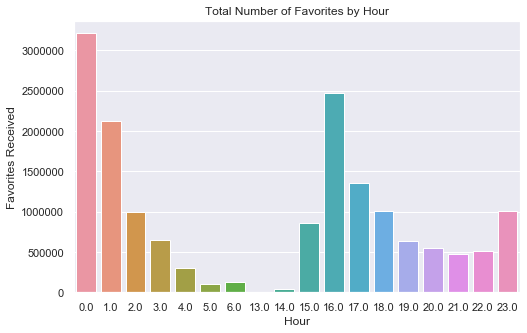

In [122]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x='hour',y= 'favourites_count', data=fav_by_hour.reset_index()).set_title('Total Number of Favorites by Hour');
plt.xlabel("Hour")
plt.ylabel("Favorites Received")
plt.show()

# Ref1: https://stackoverflow.com/questions/50029347/plot-with-seaborn-after-groupby-command-in-pandas
# Ref2: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
# Ref3: https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot

**Insight 1:**
<br>
This exhibit shows the total number of favorites received by all tweets in this dataset, broken down by hour. It can be observed that tweets posted during midnight get most of the favorites, followed by 4 pm, and then 1 am.

### `4.2` Tweets posted during which time get more retweets?

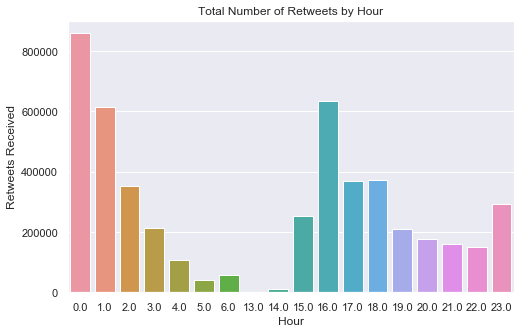

In [123]:
# Same logic as above
# Total retweet_count by hour
retw_by_hour = df.groupby('hour').retweet_count.sum()
retw_by_hour

retw_by_hour = pd.DataFrame(retw_by_hour)
retw_by_hour

sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x='hour', y='retweet_count', data=retw_by_hour.reset_index()).set_title('Total Number of Retweets by Hour')
plt.xlabel('Hour')
plt.ylabel('Retweets Received')
plt.show()

**Insight 2:**
<br>
This exhibit shows the total number of retweets received by all tweets, broken down by hour. It can be observed that tweets posted during midnight get most of the retweets, followed by 4 pm, and then 1 am. This shows a similar pattern with the number of favorites that tweets get during a day.

### `4.3` Is there a relationship between rating and favourites?

In [158]:
# Remove extremely high rating

# Extreme values (everything in the list below has only 1 count)
# df.rating_numerator.value_counts().index.tolist()

extr_r = [420.0,99.0,165.0,204.0,121.0,45.0,1776.0,84.0,88.0,144.0,26.0,75.0,44.0,60.0,80.0,50.0,27.0,24.0,143.0]
index_to_drop = []
  
for index, row in df.iterrows():
    if row['rating_numerator'] in extr_r:
        index_to_drop.append(index)
index_to_drop

df_no_extr_r = df.drop(index=index_to_drop)
df_no_extr_r.shape

(2056, 23)

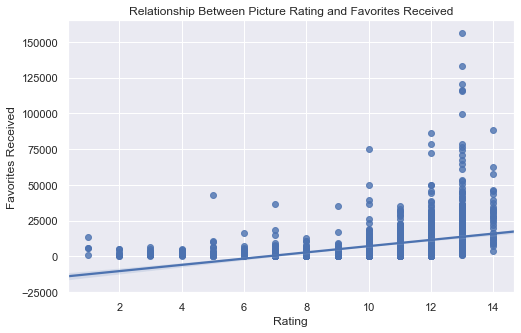

In [161]:
sns.regplot(x="rating_numerator", y="favourites_count", data=df_no_extr_r).set_title('Relationship Between Picture Rating and Favorites Received');
plt.xlabel('Rating')
plt.ylabel('Favorites Received')
plt.show()

**Insight 3:**
<br>
There is a positive relationship between the rating of the picture in a tweet and the number of favorites this tweet gets. The pattern shows that the higher the rating is, the more favorites it has. 

### `4.4` Is there a relationship between rating and retweets?

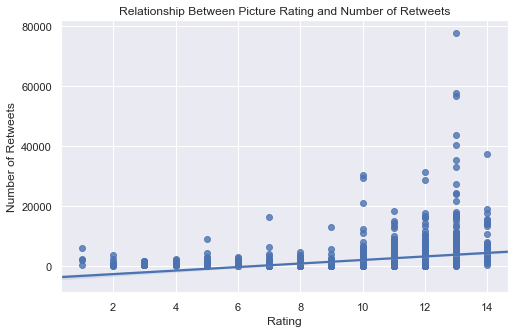

In [162]:
sns.regplot(x="rating_numerator", y="retweet_count", data=df_no_extr_r).set_title('Relationship Between Picture Rating and Number of Retweets');
plt.xlabel('Rating')
plt.ylabel('Number of Retweets')
plt.show()

**Insight 4:**
<br>
There is a positive relationship between the rating of the picture in a tweet and the number of retweets this tweet gets. The pattern shows that the higher the rating is, the more retweets it has. 

### Limitation:
<br>
From the analysis above, we can observe a positive relationship between rating and number of favorites received, and between rating and number of retweets. However, cause-and-effect relationship cannot be concluded. Further analysis needs to be conducted to decide if one factor causes the change in another factor.